In [1]:
import numpy as np
import healpy as hp
from astropy import units as u
from astropy import coordinates as cc
from math import pi
import matplotlib.pyplot as plt

In [2]:
## Function to create galactocentric-frame disk density distribution of DWD population following Breivik et al. (2020).
## rh is the radial scale height in kpc, zh is the vertical scale height in kpc. The distribution is azimuthally symmetric.
## Returns: tot_dense_3D, a cylindrical coordinate WD density distribution in galactocentric coordinates
def compute_density(rh, zh):
    ## set grid density
    grid_fill = 200
    ## create grid *in cartesian coordinates*
    ## distances in kpc
    gal_rad = 20
    xs = np.linspace(-gal_rad,gal_rad,grid_fill)
    ys = np.linspace(-gal_rad,gal_rad,grid_fill)
    zs = np.linspace(-5,5,grid_fill)
    x, y, z = np.meshgrid(xs,ys,zs)
    r = np.sqrt(x**2 + y**2)
    ## Calculate density distribution
    rho_c = 1e4 # some fiducial central density (?? not sure what to use for this)
    r_cut = 2.1 #kpc
    r0 = 0.075 #kpc
    alpha = 1.8
    q = 0.5
    disk_dense = rho_c*np.exp(-r/rh)*np.exp(-np.abs(z)/zh) 
    bulge_dense = rho_c*(np.exp(-(r/r_cut)**2)/(1+np.sqrt(r**2 + (z/q)**2)/r0)**alpha)
    tot_dense = disk_dense + bulge_dense
    return tot_dense, x, y, z

In [3]:
## Call density function and transform to SSB coordinates
## Thin disk has rh=2.9kpc, zh=0.3kpc; Thick disk has rh=3.31kpc, zh=0.9kpc
DWD_density, x, y, z = compute_density(2.9,0.3) #3.31,0.9)
gc = cc.Galactocentric(x=x*u.kpc,y=y*u.kpc,z=z*u.kpc)
SSBc = gc.transform_to(cc.Galactic)

In [4]:
## Calculate strain and power contributions per grid point
## UNNORMALIZED (!!!! - need to figure this out)
## Strain contribution from a grid point goes as density*(1/distance)
strains = DWD_density*(np.array(SSBc.distance))**-1
#Power contribution goes as strain^2
powers = strains**2 
## Filter high-power binaries, roughly top half (*shrug*)
filtered_powers = (powers < 1)*powers

In [5]:
## Transform to healpix basis
nside = 24
pixels = hp.ang2pix(nside,np.array(SSBc.l),np.array(SSBc.b),lonlat=True)

In [6]:
## Create Map
skymap = np.zeros(hp.nside2npix(nside))
## Bin
for i in range(skymap.size):
    skymap[i] = np.sum((pixels==i)*powers)
logskymap = np.log10(skymap + 10**-15 * (skymap==0))

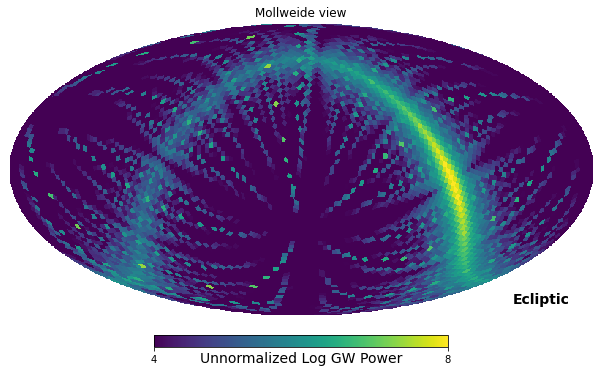

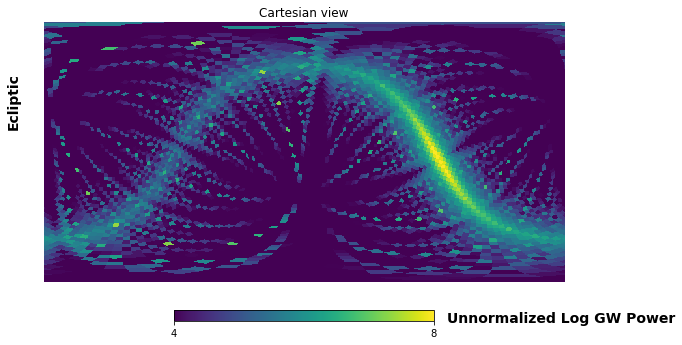

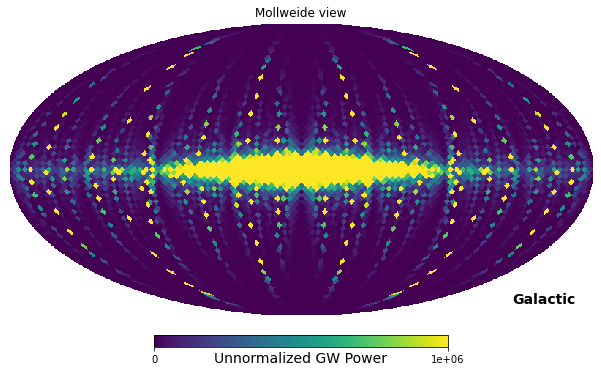

In [18]:
## Plot Log
hp.mollview(logskymap, coord=['G','E'], unit='Unnormalized Log GW Power',min=4,max=8)
hp.cartview(logskymap, coord=['G','E'], unit='Unnormalized Log GW Power',min=4,max=8)
## Plot Linear
hp.mollview(skymap, coord=['G'], unit='Unnormalized GW Power',min=0, max=1e6)

In [8]:
# ## Create Filtered Map
# fskymap = np.zeros(hp.nside2npix(nside))
# ## Bin
# for i in range(skymap.size):
#     fskymap[i] = np.sum((pixels==i)*filtered_powers)
# flogskymap = np.log10(fskymap + 10**-15 * (fskymap==0))

In [9]:
# ## Plot Log
# hp.mollview(flogskymap, coord=['G'], unit='Unnormalized Log GW Power')
# ## Plot Linear
# hp.mollview(fskymap, coord=['G'], unit='Unnormalized GW Power')

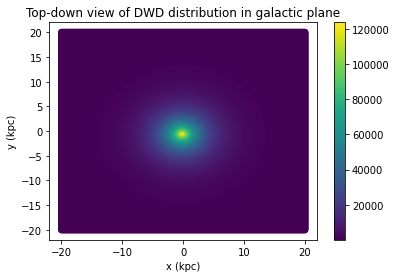

In [10]:
plt.scatter(x[:,:,0],y[:,:,0],c=np.sum(DWD_density,axis=2))
plt.title("Top-down view of DWD distribution in galactic plane")
plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")
plt.colorbar()
plt.show()

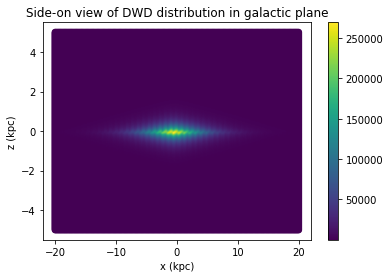

In [11]:
plt.scatter(x[0,:,:],z[0,:,:],c=np.sum(DWD_density,axis=0))
plt.title("Side-on view of DWD distribution in galactic plane")
plt.xlabel("x (kpc)")
plt.ylabel("z (kpc)")
# plt.xlim(-15,15)
# plt.ylim(-5,5)
plt.colorbar()
plt.show()

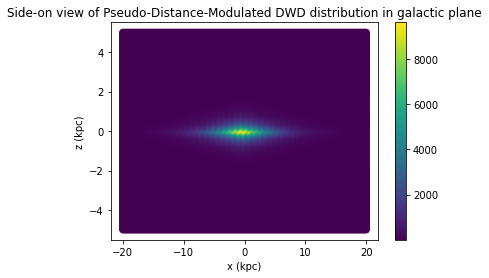

In [12]:
plt.scatter(x[0,:,:],z[0,:,:],c=np.sum(DWD_density/(np.abs(8-y[0,:,0])),axis=0))
plt.title("Side-on view of Pseudo-Distance-Modulated DWD distribution in galactic plane")
plt.xlabel("x (kpc)")
plt.ylabel("z (kpc)")
plt.colorbar()
plt.show()

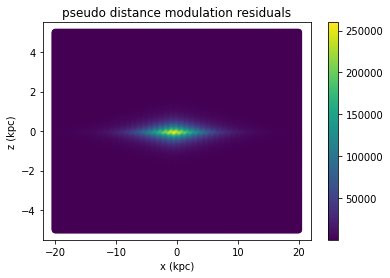

In [13]:
plt.scatter(x[0,:,:],z[0,:,:],c=(np.sum(DWD_density,axis=0) - np.sum(DWD_density/(np.abs(8-y[0,:,0])),axis=0)))
plt.title("pseudo distance modulation residuals")
plt.xlabel("x (kpc)")
plt.ylabel("z (kpc)")
plt.colorbar()
plt.show()